#### Читаем данные:

In [1]:
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions._

val spark = org.apache.spark.sql.SparkSession.builder
        .master("local")
        .appName("Spark CSV Reader")
        .getOrCreate;

 val recipes = spark.read
        .format("csv")
        .option("header", "true")
        .option("inferSchema", "true")
        .load("recipes.csv")

 val interactions = spark.read
        .format("csv")
        .option("header", "true")
        .option("inferSchema", "true")
        .load("interactions.csv")

Intitializing Scala interpreter ...

Spark Web UI available at http://e14c60f0b525:4040
SparkContext available as 'sc' (version = 3.0.1, master = local[*], app id = local-1604873783815)
SparkSession available as 'spark'


import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions._
spark: org.apache.spark.sql.SparkSession = org.apache.spark.sql.SparkSession@3ef137e2
recipes: org.apache.spark.sql.DataFrame = [name: string, id: int ... 10 more fields]
interactions: org.apache.spark.sql.DataFrame = [user_id: int, recipe_id: int ... 3 more fields]


In [2]:
recipes.selectExpr("count(distinct id)").show()

+------------------+
|count(DISTINCT id)|
+------------------+
|            231637|
+------------------+



0. Посмотрите на данные

In [ ]:
recipes.printSchema; interactions.printSchema

Итак `recipes` - состоит из 12 колонок, `interactions` -  из 5. Кажется данные взяты с какого-то кулираного сайта, где пользователи смотрят рецепты и комментируют

1. Найдите пользователя с максимальным количеством отзывов

In [ ]:
interactions
    .groupBy("user_id")
    .agg(count("*") as "feedbacks")
    .orderBy(-$"feedbacks")
    .take(1)

// ответ: user_id 424680

**ANS: 424680**

2. Найдите пользователя, который потратил больше всех времени на готовку (придумайте как это примерно посчитать с имеющимися данными)

In [73]:
interactions
    .select("user_id", "recipe_id")
    .join(recipes, interactions("recipe_id") === recipes("id"), "inner")
    .groupBy("user_id")
    .agg(
        count("*") as "cnt_recipie",
        sum("minutes") as "minutes_sum"
    )
    .orderBy(-$"minutes_sum")
    .show(10)

//Ans: 424680

+-------+-----------+-----------+
|user_id|cnt_recipie|minutes_sum|
+-------+-----------+-----------+
| 424680|       7671| 2148367661|
| 222564|       2073| 2148016493|
| 482376|       1719| 2147619603|
| 573325|       1207| 2147569146|
| 237123|        462| 2147556014|
| 315565|       1015| 2147551999|
| 213139|        857| 2147550635|
| 228458|        622| 2147524546|
| 407007|        453| 2147511110|
| 385678|        336| 2147501802|
+-------+-----------+-----------+
only showing top 10 rows



In [213]:
interactions
    .join(recipes, interactions("recipe_id") === recipes("id"), "inner")
    .filter($"user_id" === 424680)
    .select("user_id", "minutes", "recipe_id")
    .count

res180: Long = 7671


**ANS: 424680**

3. Найдите пользователя, который дольше всего пользуется сайтом (придумайте как это примерно посчитать с имеющимися данными)


In [85]:
interactions
    .select($"date")
    .show(10)

+----------+
|      date|
+----------+
|2003-02-17|
|2011-12-21|
|2002-12-01|
|2010-02-27|
|2011-10-01|
|2005-05-21|
|2011-08-06|
|2015-05-10|
|2005-09-02|
|2005-12-22|
+----------+
only showing top 10 rows



In [120]:
val firstDate = interactions
                    .selectExpr("min(date)")
                    .take(2)

val firstDate_str = firstDate(0).getString(0)

firstDate: Array[org.apache.spark.sql.Row] = Array([2000-01-25])


In [126]:
interactions
    .filter($"date" === firstDate_str)
    .select("user_id")
    .show

+-------+
|user_id|
+-------+
|   2008|
|   2008|
+-------+



In [ ]:
// check

interactions
    .filter($"user_id" === 2008)
    .show

**Ответ: 2008**

4. Найдите пользователя, который берёт только новые рецепты (придумайте как это примерно посчитать с имеющимися данными)

In [15]:
// не зыбть вместо отрицательный чисел поставить 0

interactions
    .join(recipes, interactions("recipe_id") === recipes("id"), "inner")
    .select("user_id", "id", "date", "submitted")
    .withColumn("datediff_days", datediff($"date", $"submitted"))
    .where("datediff_days > -1")
    .groupBy("user_id")
    .agg(
        count("*") as "cnt_meal",
        sum("datediff_days") as "sum_per_user"
    )
    .orderBy(struct($"sum_per_user", -$"cnt_meal"))
    .show


+----------+--------+------------+
|   user_id|cnt_meal|sum_per_user|
+----------+--------+------------+
|     67344|       4|           0|
|    543644|       4|           0|
|    238395|       3|           0|
|1803072009|       2|           0|
|   2734292|       2|           0|
|   2198435|       2|           0|
|   1684663|       2|           0|
|   1271572|       2|           0|
|   2193344|       2|           0|
|   2691191|       2|           0|
|   2199258|       2|           0|
|   1131759|       2|           0|
|1803066303|       2|           0|
|   2719902|       2|           0|
|   2733922|       2|           0|
|   1640593|       2|           0|
|    560807|       1|           0|
|    338428|       1|           0|
|    579241|       1|           0|
|   2688526|       1|           0|
+----------+--------+------------+
only showing top 20 rows



### Проверка

In [16]:
interactions
    .filter($"user_id" === 67344)
    .show

+-------+---------+----------+------+--------------------+
|user_id|recipe_id|      date|rating|              review|
+-------+---------+----------+------+--------------------+
|  67344|    50456|2003-01-08|     5|Unique and delicous!|
|  67344|    50430|2003-01-08|     5|Light but satisfy...|
|  67344|    50436|2003-01-08|     5|this was to die f...|
|  67344|    50453|2003-01-08|     5|Light and quick d...|
+-------+---------+----------+------+--------------------+



In [22]:
recipes
    .filter($"id" === 50456 || $"id" === 50430 || $"id" === 50436 || $"id" === 50453)
    .select("id", "submitted", "name", "minutes")
    .show

+-----+----------+--------------------+-------+
|   id| submitted|                name|minutes|
+-----+----------+--------------------+-------+
|50456|2003-01-08|mom s famous grah...|    100|
|50430|2003-01-08|teresa s 10 minut...|     13|
|50436|2003-01-08|teresa s chicken ...|     25|
|50453|2003-01-08|teresa s veal  or...|     15|
+-----+----------+--------------------+-------+



**Вывод:** Рецепты появились на сайте и были приготовлены в один день

**Ответ:** 67344

5. Найдите пользователя, который выбирает самые сложные рецепты. Метрика: 0.2 * (медианное количество шагов в выбранном рецепте) + 0.3 * (среднее количество ингредиентов) + (длина описания, нормированная на максимальную длину описания)

In [ ]:
val max_descr = recipes
                    .selectExpr("max(description) as m")
                    .take(1)

val max_descr_str_length = max_descr(0).getString(0).length.toFloat

In [ ]:
val metrics = recipes
    .select(
        $"id" as "recipe_id",
        $"n_steps",
        $"n_ingredients",
        length($"description") as "desc_len"
    )
    .withColumn("n_ingredients", $"n_ingredients")
    .filter($"n_ingredients" isNotNull)

In [350]:
val recipes_cast = recipes
    .withColumn("n_ingredients", $"n_ingredients" cast("Int"))
    .withColumn("n_steps", $"n_steps" cast("Int"))
    .filter($"n_ingredients" isNotNull)

interactions
    .select("user_id", "recipe_id")
    .join(recipes_cast, $"user_id" === $"id")
    .groupBy("user_id")
    .agg(
        mean("n_ingredients") as "ingredients_cnt",
        callUDF("percentile_approx", col("n_steps"), lit(0.5)) as "steps_cnt", //медиана
        mean(length($"description")) / max_descr_str_length as "desc_normalize"
    )
    .withColumn("metric", $"steps_cnt" * 0.2 + $"ingredients_cnt" * 0.3 + $"desc_normalize")
    .orderBy(-$"metric")
    .show(1)

+-------+---------------+---------+-------------------+----------------+
|user_id|ingredients_cnt|steps_cnt|     desc_normalize|          metric|
+-------+---------------+---------+-------------------+----------------+
| 171610|         2006.0|        3|0.03699551569506727|602.436995515695|
+-------+---------------+---------+-------------------+----------------+
only showing top 1 row



recipes_cast: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [name: string, id: int ... 10 more fields]


**Ответ: 171610**

6. Найдите количество пользователей, которые выбирают наиболее разнообразную пищу. 2 вариации:
    1. На основании тэгов
    2. На основании лемматизированных описаний и TF-IDF

In [298]:
val cnt_recipe_per_user = recipes
    .join(interactions, interactions("recipe_id") === recipes("id"), "inner")
    .groupBy( "user_id")
    .agg(count("*").cast("float") as "cnt")

val uniqueTags = recipes
    .select($"id" as "recipe_id", explode(split(expr("substring(tags, 2, length(tags) - 1)"), ",")) as "tags")
    .join(interactions.select("user_id", "recipe_id"), Seq("recipe_id"))
    .groupBy("user_id")
    .agg(countDistinct("tags") as "unique_tags_cnt")
    .orderBy(-$"unique_tags_cnt")

uniqueTags: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [user_id: int, unique_tags_count: bigint]


In [317]:
// первая ячейка

uniqueTags
    .join(cnt_recipe_per_user, cnt_recipe_per_user("user_id") === uniqueTags("user_id"))
    .withColumn("avg_tags", $"unique_tags_cnt"/$"cnt") 
    .orderBy(-$"unique_tags_cnt")
    .show

+-------+-----------------+-------+------+-------------------+
|user_id|unique_tags_count|user_id|   cnt|           avg_tags|
+-------+-----------------+-------+------+-------------------+
| 424680|              643| 424680|7671.0|0.08382218745926216|
|  37449|              606|  37449|5603.0|0.10815634481527753|
| 169430|              580| 169430|4076.0| 0.1422963689892051|
| 128473|              578| 128473|3917.0| 0.1475619096247128|
|  58104|              571|  58104|3288.0|  0.173661800486618|
| 133174|              559| 133174|3107.0| 0.1799163179916318|
| 107135|              557| 107135|2020.0|0.27574257425742577|
| 383346|              551| 383346|4628.0|0.11905790838375108|
| 226863|              551| 226863|2874.0|0.19171885873347252|
|  80353|              548|  80353|2220.0|0.24684684684684685|
| 498271|              542| 498271|2644.0|0.20499243570347958|
| 131126|              541| 131126|2138.0| 0.2530402245088868|
|  89831|              534|  89831|3353.0|0.15926036385

In [318]:
// вторая ячейка

uniqueTags
    .join(cnt_recipe_per_user, cnt_recipe_per_user("user_id") === uniqueTags("user_id"), "left")
    .withColumn("avg_tags", $"unique_tags_count"/$"cnt") 
    .orderBy(-$"avg_tags")
    .show

+----------+-----------------+----------+---+--------+
|   user_id|unique_tags_count|   user_id|cnt|avg_tags|
+----------+-----------------+----------+---+--------+
|1803050464|               68|1803050464|1.0|    68.0|
|1802640046|               68|1802640046|1.0|    68.0|
|1800225281|               68|1800225281|1.0|    68.0|
|2001286124|               68|2001286124|1.0|    68.0|
|   1434863|               68|   1434863|1.0|    68.0|
|    852602|               68|    852602|1.0|    68.0|
|   1112186|               68|   1112186|1.0|    68.0|
|    246492|               68|    246492|1.0|    68.0|
|2001985095|               68|2001985095|1.0|    68.0|
|    191658|               68|    191658|1.0|    68.0|
|     99971|               68|     99971|1.0|    68.0|
|   1543399|               68|   1543399|1.0|    68.0|
|   1376859|               68|   1376859|1.0|    68.0|
|    412777|               68|    412777|1.0|    68.0|
|    108682|               68|    108682|1.0|    68.0|
|   138788

**Ответ:**

Условие можно понимать по-разнному, если интересует:

    - *наиболее* разнообразный человек, то это 424680 (первая ячейка)
    - максимальное соотношение числа тегов к количеству рецептов, то это список выше (вторая ячейка)

7. 


а) Найдите медианное значение калорийности блюд, приготовленных пользователями с более чем 5-ю отзывами

б) В качестве веса в медиане используйте количество отзывов на блюдо. Взвешенную медиану необходимо реализовать через оконные функции

Для нахождения медианы используем `callUDF("percentile_approx", $"comment_count", lit(0.5))`

In [ ]:
// TODO: сначала понять

8. Найдите слова в отзыве, которые наиболее коррелируют с хорошим рейтингом (4-5). Отфильтруйте слишком редкие слова

In [34]:
%%time

// рабочее
interactions
    .select($"rating", explode(split(lower(regexp_replace($"review","[^a-zA-Z ]", "")), " ")) as "word")
    .filter($"word" !== "")
    .withColumn("word_count", count("*") over Window.partitionBy($"word")) // общее количество вхождения слова
    .filter($"word_count" >= 200 && $"rating" > 3)
    .withColumn("correlation", count("*") over Window.partitionBy($"word"))
    .distinct
    .select($"word", $"correlation" / $"word_count" as "correlation", $"word_count")
    .orderBy(-$"correlation")
    .show

+----------+------------------+----------+
|      word|       correlation|word_count|
+----------+------------------+----------+
| honkitten|               1.0|       348|
|  gailanng|               1.0|       222|
| honkitten|               1.0|       348|
|  gailanng|               1.0|       222|
|  adoptees| 0.998158379373849|      1086|
|  adoptees| 0.998158379373849|      1086|
|aussiekiwi|0.9960474308300395|       253|
|aussiekiwi|0.9960474308300395|       253|
| againmade|0.9957264957264957|       234|
| againmade|0.9957264957264957|       234|
|    boomie|0.9956709956709957|       231|
|    boomie|0.9956709956709957|       231|
| travelers|0.9955555555555555|       225|
| travelers|0.9955555555555555|       225|
| recipenap|0.9952380952380953|       210|
| recipenap|0.9952380952380953|       210|
|      pets|0.9951923076923077|       208|
|      pets|0.9951923076923077|       208|
|      kitz| 0.995049504950495|       202|
|      kitz| 0.995049504950495|       202|
+----------

9. Найдите теги, блюда с которыми имеют в среднем худшие отзывы

In [6]:
%%time

recipes
    .select($"id", explode(split(expr("substring(tags, 2, length(tags)-1)"), ", ")) as "tag")
    .withColumn("tag", trim($"tag", "' []"))
    .join(interactions, $"id" === $"recipe_id")
    .select("recipe_id", "rating", "tag")
    .groupBy("tag")
    .agg(mean("rating") as "mean_rating")
    .orderBy("mean_rating")
    .show

+--------------------+------------------+
|                 tag|       mean_rating|
+--------------------+------------------+
|      beef-crock-pot|               0.0|
|lamb-sheep-main-dish|               0.0|
|   main-dish-seafood|               0.0|
|    shrimp-main-dish|               0.0|
|           pot-roast|               0.0|
|           bean-soup|               3.0|
|     black-bean-soup|               3.0|
|      main-dish-beef|               3.0|
|       stews-poultry|3.3333333333333335|
|                bear|3.6666666666666665|
|    pressure-canning|3.6742424242424243|
|       sugar-cookies| 3.707070707070707|
|            honduran|3.7982456140350878|
| unprocessed-freezer| 3.824915824915825|
|fillings-and-fros...|3.9347826086956523|
|            birthday| 3.944741532976827|
|             jellies|3.9685714285714284|
|          water-bath|3.9867256637168142|
|    beef-barley-soup|               4.0|
|high-in-something...|               4.0|
+--------------------+------------

10. Найдите contributor'а, который прислал:
    1. Наиболее используемый рецепт
    2. Наиболее высоко оцененный рецепт

In [11]:
val recipeUserMetrics = 
interactions
    .groupBy("recipe_id")
    .agg(count("*") as "cnt", mean("rating") as "mean_rating")
    .join(recipes, $"id" === $"recipe_id")
    .groupBy("contributor_id")
    .agg(max("cnt") as "max_cnt", max("mean_rating") as "max_rating")
    .filter($"max_rating" === 5.0)
    .orderBy(-$"max_cnt")
    .show(1)

+--------------+-------+----------+
|contributor_id|max_cnt|max_rating|
+--------------+-------+----------+
|          1762|   1613|       5.0|
+--------------+-------+----------+
only showing top 1 row



recipeUserMetrics: Unit = ()


11. Опишите процесс работы broadcast join

`broadcast join` используются при join маленького датафрейма с большим, для оптимизации времени исполнения запроса.
Spark - разделяет данные на разных узлах кластера, чтобы впоследствии обрабатывать запросы паралелльно. Понятно, что мы хотим минимизировать количество операций перебора которые происходят при join, поэтому просто закинем маленькую таблицу во все узлы кластера сразу(на все рабочие машины).  Как раз для этого и пользуеемся **broadcast**: `.join(broadcast(small_df_name), ...)`.

12. Опишите процесс работы cache и причины его использования

**Как работает?**

На этапе планирование запроса spark делает следующее: 

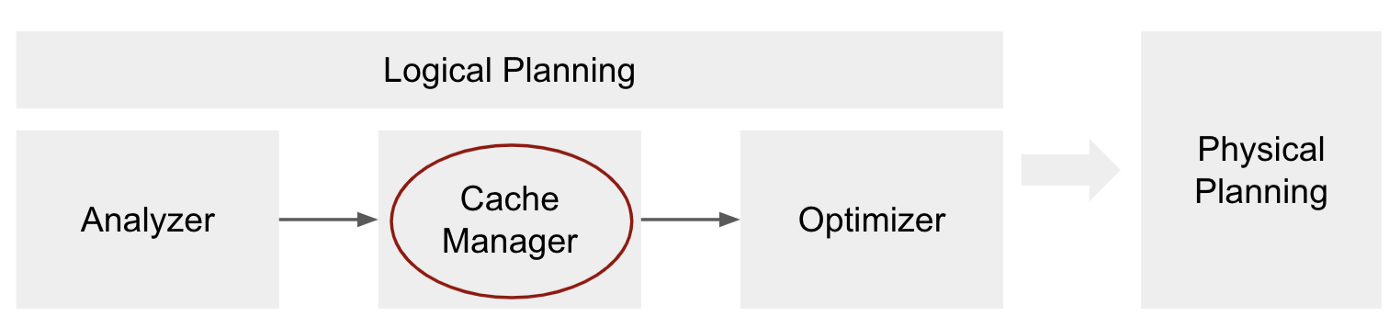

> "When you run a query with an action, the query plan will be processed and transformed. In the step of the Cache Manager (just before the optimizer) Spark will check for each subtree of the analyzed plan if it is stored in the cachedData sequence. If it finds a match it means that the same plan (the same computation) has already been cached (perhaps in some previous query) and so Spark can use that and thus it adds that information to the query plan using the InMemoryRelation operator which will carry information about this cached plan."


**Почему стоит использовать:**

RDD.cache по-прежнему ленивая операция, которая "ничего не делает". Но если мы вызовем df.count 2 раза, то во второй раз spark достанет значение из кеша, а не будет его пересчитывать. Соответственно, если вы часто работаете с какими-то данными, стоит использовать .cache